In [30]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
import pandas as pd
% matplotlib inline

In [31]:
# Define BCM class by quadratic local learning rule
# Relu activation function
# Update weight per sample
# Enable batch normalization
# Enable objective function

class BCM:
    """BCM learning
    Parameter:
    eta: float, learning rate (between 0.0 - 1.0)
    n_iter: int, passes over the training dataset
    ny: number of output neurons
    batchsize: float, percentage of data that are used to update the weight once
    
    Attributes:
    w_: 1d-array, weights after fitting
    error_: list, number of misclassification in every epoch
    """
    def __init__(self, eta = 0.1,n_epoch = 10,ny = 1,batch = 10, tau = 100,thres = 0, p = 2,random_state = None, shuffle = True,nonlinear = None, obj_type = 'QBCM'):
        self.eta = eta
        self.n_epoch = n_epoch
        self.ny = ny
        self.tau = tau  # Time constant for calculating thresholds
        self.thres = thres*np.ones(ny)
        self.p = p    # int, power for threshold computation
        self.y_thres = []      # Storaged y for studying effect of threshold
        self.shuffle = shuffle
        self.nonlinear = nonlinear
        self.batch = batch
        
        if random_state:
            seed(random_state)
            
    def fit(self,X):
        """fitting training data
        Parameter:
        X: {array-like}, shape = [n_samples,n_features]
        Returns: self:object
        ny: value, number of output neurons
        """
        # Weights initialized as normal distribution
        self.w_ = np.random.randn(X.shape[1],self.ny) # 2*1
        self.w_track = []
        self.obj = []
        
        # Use elementwise training 
        threshold = self.thres
        self.thres = []
        self.obj = []
        obj_x1 = np.zeros(self.ny)   # Two iterative terms in objective function
        obj_x2 = np.zeros(self.ny)   # Two iterative terms in objective function
        obj = np.zeros(self.ny)
        for _ in range(self.n_epoch):
            if self.shuffle:
                X = self._shuffle(X)
            if self.batch:
                X_batch = []
                for k in range(0,X.shape[0],self.batch):
                    X_batch.append(np.mean(X[k:k+self.batch,:],axis = 0))
                X_batch = np.vstack(X_batch)
            for i, xi in enumerate(X_batch):   # elementwise training for all samples
                y = np.zeros(ny)
                for j in range(self.ny):
                    y[j] = np.dot(xi,self.w_[:,j])
                    if self.nonlinear == 'Sigmoid':
                        y[j] = self._sigmoid (y[j])
                    elif self.nonlinear == 'Relu':
                        y[j] = (y[j]>=0)* y[j]
                    self.w_[:,j][:,None] = self.w_[:,j][:,None]+ self.eta * xi[:,None]* y[j]*(y[j] - threshold[j])
                    threshold[j] = self._ema(x = threshold[j],y = y[j],power = self.p)  #
#                    obj_x1[j],obj_x2[j],obj[j] = self._obj(x1 = obj_x1[j], x2 = obj_x2[j],y = y[j],power1 = 3, power2 = 2)
                    obj[j] = self._obj(X,w = self.w_[:,j])
                w_tmp = np.concatenate(self.w_.T, axis=0)    # make 2*2 matrix into 1*4, preparing for weight tracking
                self.y_thres.append(y)
                self.thres.append(threshold.tolist())
                self.w_track.append(w_tmp.tolist())
                self.obj.append(obj.tolist())
        return self
    
    def _shuffle(self,X):
        r = np.random.permutation(len(X))
        return X[r]
    
    def _sigmoid(self,z):
        return 1/(1+np.exp(-z))
    
    def _ema(self,x,y,power = 2):    #Good way to implement exponential moving average
        # x is the iterative variable, y is the function being averaged
        h = np.exp(-1/self.tau)
        return x*h+(y**power)*(1-h)

# objective function using sequential data
#     def _obj(self,x1,x2,y,power1,power2):
#         x1 = self._ema(x = x1,y = y,power = power1)
#         x2 = self._ema(x = x2,y = y,power = power2)
#         obj = 1/3*x1 - 1/4*x2**2
#         #obj = x1 - 3*x2**2
#         return x1,x2,obj


# objective function using all data
    def _obj(self,X,w,obj_type = 'QBCM'):
        c = np.dot(X,w)
        if self.nonlinear == 'Sigmoid':
            c = self._sigmoid (c)
        elif self.nonlinear == 'Relu':
            c = (1-(c<0))* c
            
        if obj_type == 'QBCM':
            obj1 = (c**3).mean(axis = 0)
            obj2 = (c**2).mean(axis = 0)
            obj = obj1/3 - obj2**2/4
        elif obj_type == 'kurtosis':
            obj1 = (c**4).mean(axis = 0)
            obj2 = (c**2).mean(axis = 0)
            obj = obj1 - obj2**2*3
        elif obj_type == 'skewness':
            obj1 = (c**3).mean(axis = 0)
            obj2 = (c**2).mean(axis = 0)
            obj = np.divide(obj1,obj2**1.5)
            
        return obj

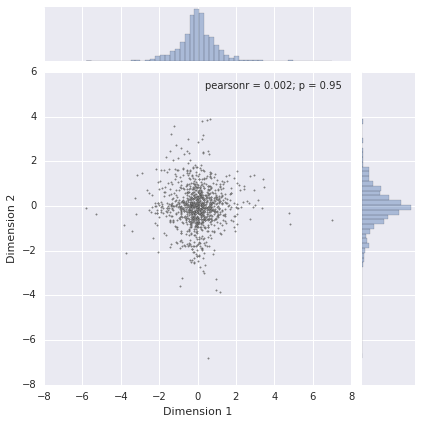

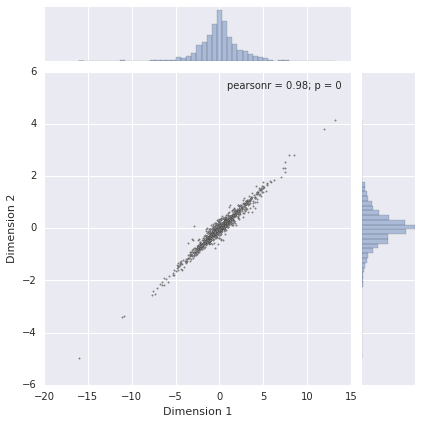

In [50]:
# Sample from the above distribution
loc = 0   # Mean zero
scale = (2**0.5)**(-1)
s = np.random.laplace(loc,scale,[1000,2])  # 5000*2, 0 mean, unit variance

# make data skewed with a half-squaring
# idx = s[:,1] > 0
# s[idx,1] = s[idx,1]**2

# Conduct rotation and mixture
# Generate rotation matrix
theta = np.pi/4      # 45 degree rotation
#A = np.array(((mt.cos(theta),-mt.sin(theta)),(mt.sin(theta),mt.cos(theta))))
A = np.random.randn(2,2)
#A = np.dot(A, A.T)

s_rt = np.dot(s,A)

# plot original distribution
df = pd.DataFrame({'x':s[:,0],'y':s[:,1]})
g = sns.jointplot(x="x", y="y", data=df)
g.plot_joint(plt.scatter, c="gray", s=10, linewidth=.1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Dimension 1", "Dimension 2")



# plot mixed distribution
df = pd.DataFrame({'x':s_rt[:,0],'y':s_rt[:,1]})
g = sns.jointplot(x="x", y="y", data=df)
g.plot_joint(plt.scatter, c="gray", s=10, linewidth=.1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Dimension 1", "Dimension 2")


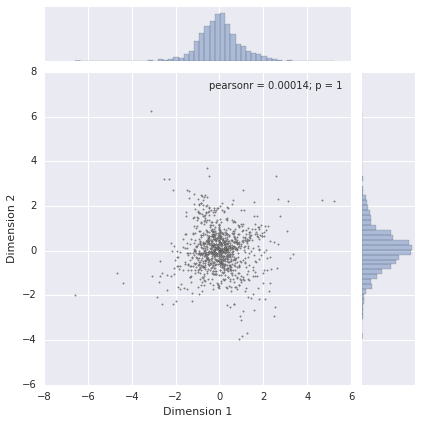

In [51]:
# Perform zca whitening
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    #ZCAMatrix = np.dot(U, np.diag(1.0/np.sqrt(S + epsilon))) # [M x M]
    return ZCAMatrix

ZCAMatrix = zca_whitening_matrix(s_rt.T)
s_rt_wt = np.dot(s_rt,ZCAMatrix)
# Generate 2d satter plot of the whitened data
df = pd.DataFrame({'x':s_rt_wt[:,0],'y':s_rt_wt[:,1]})
g = sns.jointplot(x="x", y="y", data=df)
g.plot_joint(plt.scatter, c="gray", s=10, linewidth=.1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Dimension 1", "Dimension 2")


done in 16.082s


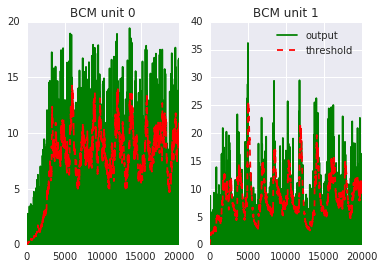

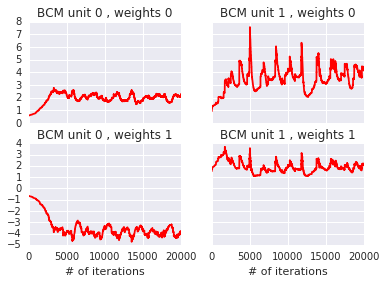

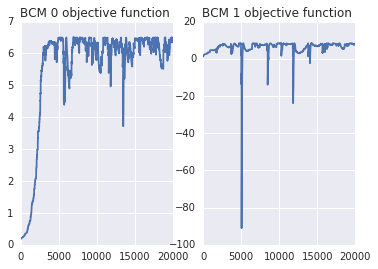

In [82]:
# Train BCM model with Laplace data

ny = 2    # 2 output neurons
n_epoch = 20
p = 2
eta = 0.0005
tau = 200
batch = 1
BCM_laplace = BCM(eta = eta,n_epoch = n_epoch,batch = batch,ny = ny,tau = tau, thres = 0, p = p,random_state = None, shuffle = True, nonlinear = 'Relu', obj_type = 'QBCM')

t0 = time()
BCM_laplace.fit(s_rt_wt)
print("done in %0.3fs" % (time()-t0))

#x_plot = range(n_iter * len(X))
plt_range = n_epoch * len(s_rt_wt)
BCM_laplace_thres = np.vstack(BCM_laplace.thres)
BCM_laplace_out = np.vstack(BCM_laplace.y_thres)
BCM_laplace_w = np.vstack(BCM_laplace.w_track)
BCM_laplace_obj = np.vstack(BCM_laplace.obj)

n_row = 1
n_column = ny

BCM_laplace_titles= ["BCM unit %d" % i for i in range (ny)]
# Plot y and threshold
for i in range(ny):
    plt.subplot(n_row,n_column,i+1)
    plt.plot(BCM_laplace_out[:plt_range,i],'g-',label = 'output')
    plt.plot(BCM_laplace_thres[:plt_range,i],'r--',label = 'threshold')
    plt.title(BCM_laplace_titles[i])

plt.legend(loc = 'upper right')

plt.figure()
# Plot weights

BCM_laplace_titles= ["BCM weights %d" % i for i in range (len(BCM_laplace_w.T))]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(BCM_laplace_w[:,0],'r',label = 'weight')
ax1.set_title("BCM unit %d , weights %d" % (0,0))
ax2.plot(BCM_laplace_w[:,2],'r',label = 'weight')
ax2.set_title("BCM unit %d , weights %d" % (1,0))
ax3.plot(BCM_laplace_w[:,1],'r',label = 'weight')
ax3.set_title("BCM unit %d , weights %d" % (0,1))
ax3.set_xlabel('# of iterations')
ax4.plot(BCM_laplace_w[:,3],'r',label = 'weight')
ax4.set_title("BCM unit %d , weights %d" % (1,1))
ax4.set_xlabel('# of iterations')

BCM_laplace_titles= ["BCM %d objective function " % i for i in range (len(BCM_laplace_w.T))]

# plot the objective function
plt.figure()
for i in range(ny):
    plt.subplot(n_row,n_column,i+1)
    plt.plot(BCM_laplace_obj[:plt_range,i])
    plt.title(BCM_laplace_titles[i])

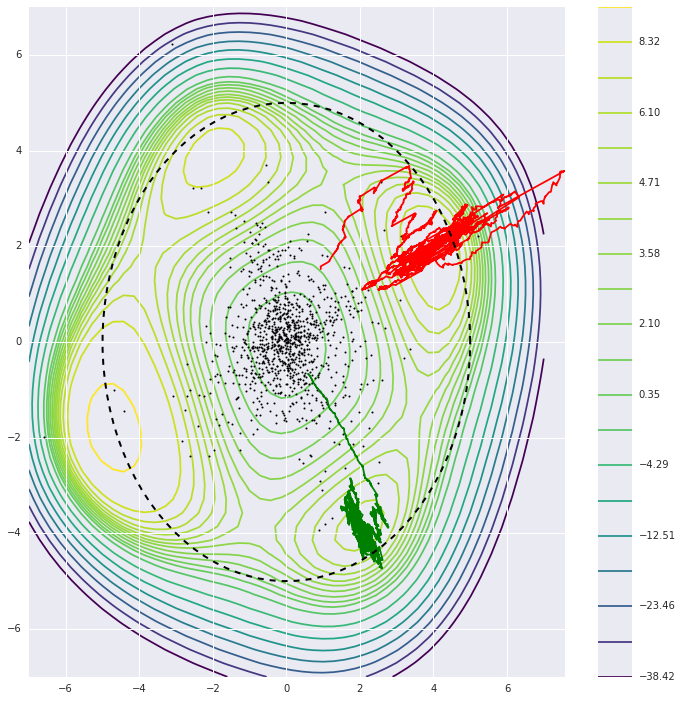

In [87]:
# Contruct objective function and 3D plot the contour
# Track the weight update trajectory

# objective function using all data
def _obj(X,w,obj_type = 'QBCM',nonlinear = None):
    c = np.dot(X,w)
    if nonlinear == 'Sigmoid':
        c = _sigmoid (c)
    elif nonlinear == 'Relu':
        c = (c >= 0)* c

    if obj_type == 'QBCM':
        obj1 = (c**3).mean(axis = 0)
        obj2 = (c**2).mean(axis = 0)
        obj = obj1/3 - obj2**2/4
    elif obj_type == 'kurtosis':
        obj1 = (c**4).mean(axis = 0)
        obj2 = (c**2).mean(axis = 0)
        obj = obj1 - 3*obj2**2
    elif obj_type == 'skewness':
        obj1 = (c**3).mean(axis = 0)
        obj2 = (c**2).mean(axis = 0)
        obj = obj1/obj2**1.5
    return obj

def _sigmoid(z):
        return 1/(1+np.exp(-z))
    
w = np.linspace(-7,7,50)
wx,wy = np.meshgrid(w,w)
w = np.vstack((wx.ravel(),wy.ravel()))
obj = _obj(s_rt_wt,w,obj_type = 'QBCM',nonlinear = 'Relu')


nbins=20
r = 5
t = np.linspace(0,2*np.pi, 100)
#levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(obj.min(),obj.max())
levels = np.percentile(obj, np.linspace(20,99,nbins))

fig, ax = plt.subplots(figsize=(12,12), sharex=True, sharey=True)
with sns.axes_style('white'):
    c = ax.contour(wx,wy,obj.reshape(wx.shape),levels=levels, zorder=-10, cmap=plt.cm.get_cmap('viridis'))
    ax.plot(s_rt_wt[:,0],s_rt_wt[:,1],'.k', ms=4)
    ax.plot(r*np.cos(t), r*np.sin(t),'--k', lw=2, zorder=20)

plt.grid('on')
plt.colorbar(c, ax=ax)

# Plot the trained weights on top
w_track = []
for i in range(0,BCM_laplace_w.shape[0],1000):
    w_track.append(BCM_laplace_w[i,:])

w_track = np.vstack(w_track)
    
plt.plot(BCM_laplace_w[:,0],BCM_laplace_w[:,1],'g')
plt.plot(BCM_laplace_w[:,2],BCM_laplace_w[:,3],'r')
    

In [70]:
np.log(obj)

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

[[ 3.60177384 -2.06787326]
 [-2.06044991 -3.07808979]]


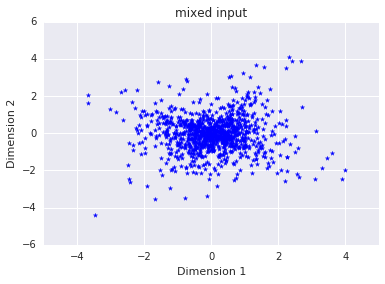

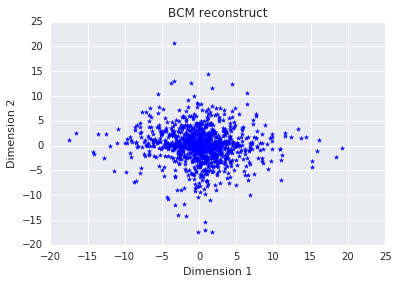

In [14]:
print(BCM_laplace.w_)

# Use the weights to reconstruct the input
s_rc = np.dot(s_rt_wt,BCM_laplace.w_)

# Generate 2d satter plot of the input data
plt.scatter(s_rt_wt[:,0],s_rt_wt[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.title('mixed input')
plt.figure()
# Generate 2d satter plot of the reconstructed data
plt.scatter(s_rc[:,0],s_rc[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.title('BCM reconstruct')

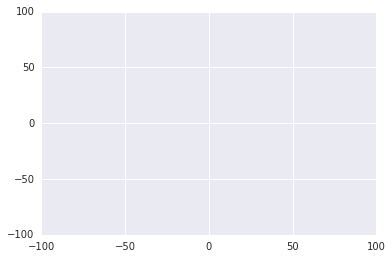

In [24]:
from matplotlib.path import Path
import matplotlib.patches as patches

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
plt.ion()
plt.show()

verts = [
    (0, 0), #I'm just assuming two sets of points here. I actually intend to put variables here which I can update in real time.
    (27, 0)
    ]

codes = [Path.MOVETO,
         Path.LINETO]  

path = Path(verts, codes)


patch = patches.PathPatch(path, facecolor='white', lw=2)
ax.add_patch(patch)
plt.draw()
